https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878

This dataset was based on the homes sold between January 2013 and December 2015

In [1]:
import pandas                       as     pd
import numpy                        as     np
import scipy.stats                  as     stats

import seaborn                      as     sns
import matplotlib.pyplot            as     plt
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

import astropy.table                as     Table
import statsmodels.api              as     sm
import statsmodels.stats.api        as     sms
from   statsmodels.compat           import lzip

from   sklearn.cross_validation     import train_test_split
from   sklearn                      import model_selection

from sklearn.linear_model           import  LinearRegression
from sklearn.linear_model           import  Lasso
from sklearn.linear_model           import  Ridge
from sklearn.linear_model           import  ElasticNet

from   sklearn.tree                 import DecisionTreeRegressor
from   sklearn.ensemble             import RandomForestRegressor
from   sklearn.neural_network       import MLPRegressor
from   sklearn                      import ensemble
from   sklearn.ensemble             import GradientBoostingRegressor

from   sklearn.neighbors            import KNeighborsRegressor
from   sklearn.svm                  import SVR

from   sklearn.model_selection      import GridSearchCV
from   sklearn.model_selection      import cross_val_score, cross_val_predict


from   sklearn.metrics              import mean_squared_error, mean_absolute_error
from   statsmodels.compat           import lzip
from   statsmodels.stats            import diagnostic as diag

from  statsmodels.stats.outliers_influence import variance_inflation_factor

D:\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
import re

def parseNumber(text):

    '''

        Return the first number in the given text for any locale.

        TODO we actually don't take into account spaces for only

        3-digited numbers (like "1 000") so, for now, "1 0" is 10.

        TODO parse cases like "125,000.1,0.2" (125000.1).   
    '''        
    
    try:

        # First we return None if we don't have anything in the text:

        if text is None:

            return None

        if isinstance(text, int) or isinstance(text, float):

            return text

        text = text.strip()

        if text == "":

            return None

        # Next we get the first "[0-9,. ]+":

        n = re.search("[0-9]*([,. ]?[0-9]+)+", text).group(0)

        n = n.strip()

        if not re.match(".*[0-9]+.*", text):

            return None

        # Then we cut to keep only 2 symbols:

        while " " in n and "," in n and "." in n:

            index = max(n.rfind(','), n.rfind(' '), n.rfind('.'))

            n = n[0:index]

        n = n.strip()

        # We count the number of symbols:

        symbolsCount = 0

        for current in [" ", ",", "."]:

            if current in n:

                symbolsCount += 1

        # If we don't have any symbol, we do nothing:

        if symbolsCount == 0:

            pass

        # With one symbol:

        elif symbolsCount == 1:

            # If this is a space, we just remove all:

            if " " in n:

                n = n.replace(" ", "")

            # Else we set it as a "." if one occurence, or remove it:

            else:

                theSymbol = "," if "," in n else "."

                if n.count(theSymbol) > 1:

                    n = n.replace(theSymbol, "")

                else:

                    n = n.replace(theSymbol, ".")

        else:

            # Now replace symbols so the right symbol is "." and all left are "":

            rightSymbolIndex = max(n.rfind(','), n.rfind(' '), n.rfind('.'))

            rightSymbol = n[rightSymbolIndex:rightSymbolIndex+1]

            if rightSymbol == " ":

                return parseNumber(n.replace(" ", "_"))

            n = n.replace(rightSymbol, "R")

            leftSymbolIndex = max(n.rfind(','), n.rfind(' '), n.rfind('.'))

            leftSymbol = n[leftSymbolIndex:leftSymbolIndex+1]

            n = n.replace(leftSymbol, "L")

            n = n.replace("L", "")

            n = n.replace("R", ".")

        # And we cast the text to float or int:

        n = float(n)

        if n.is_integer():

            return int(n)

        else:

            return n

    except: pass

    return None



In [4]:
url = 'https://raw.githubusercontent.com/RuiChang123/Regression_for_house_price_estimation/master/final_data.csv'

In [5]:
prices_df       = pd.read_csv(url)
print(prices_df.shape)
print(prices_df.head().T)

(11330, 19)
                                                               0  \
Unnamed: 0                                                     2   
address                       Address: 1160 Mission Street #2007   
info            San FranciscoSales price: 1300000Sales date: ...   
z_address                              1160 Mission St UNIT 2007   
bathrooms                                                      2   
bedrooms                                                       2   
finishedsqft                                                1043   
lastsolddate                                          02/17/2016   
lastsoldprice                                            1.3e+06   
latitude                                                 37.7787   
longitude                                               -122.413   
neighborhood                                     South of Market   
totalrooms                                                     4   
usecode                             

## Check for missing values

In [6]:
prices_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 19 columns):
Unnamed: 0       11330 non-null int64
address          11330 non-null object
info             11330 non-null object
z_address        11330 non-null object
bathrooms        11330 non-null float64
bedrooms         11330 non-null float64
finishedsqft     11330 non-null float64
lastsolddate     11330 non-null object
lastsoldprice    11330 non-null float64
latitude         11330 non-null float64
longitude        11330 non-null float64
neighborhood     11330 non-null object
totalrooms       11330 non-null float64
usecode          11330 non-null object
yearbuilt        11330 non-null float64
zestimate        11330 non-null float64
zindexvalue      11330 non-null object
zipcode          11330 non-null float64
zpid             11330 non-null float64
dtypes: float64(11), int64(1), object(7)
memory usage: 1.6+ MB


In [7]:
prices_df.isnull().sum()

Unnamed: 0       0
address          0
info             0
z_address        0
bathrooms        0
bedrooms         0
finishedsqft     0
lastsolddate     0
lastsoldprice    0
latitude         0
longitude        0
neighborhood     0
totalrooms       0
usecode          0
yearbuilt        0
zestimate        0
zindexvalue      0
zipcode          0
zpid             0
dtype: int64

There are several features that we do not need, such as “info”, “z_address”, “zipcode”(We have “neighborhood” as a location variable), “zipid” and “zestimate”(This is the price estimated by Zillow, we don’t want our model to be affected by this), so, we will drop them.

In [8]:
prices_df.drop(prices_df.columns[[0, 2, 3, 15, 17, 18]], axis=1, inplace=True)
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 13 columns):
address          11330 non-null object
bathrooms        11330 non-null float64
bedrooms         11330 non-null float64
finishedsqft     11330 non-null float64
lastsolddate     11330 non-null object
lastsoldprice    11330 non-null float64
latitude         11330 non-null float64
longitude        11330 non-null float64
neighborhood     11330 non-null object
totalrooms       11330 non-null float64
usecode          11330 non-null object
yearbuilt        11330 non-null float64
zindexvalue      11330 non-null object
dtypes: float64(8), object(5)
memory usage: 1.1+ MB


The data type of “zindexvalue” should be numeric, so let’s change that.

In [9]:
prices_df['zindexvalue'].head()

0      975,700
1      975,700
2    1,277,600
3    1,277,600
4    1,248,000
Name: zindexvalue, dtype: object

In [10]:
prices_df['zindexvalue'] = prices_df['zindexvalue'].apply(lambda x: parseNumber(x))
prices_df['zindexvalue'].head()

0        975.7
1        975.7
2    1277600.0
3    1277600.0
4    1248000.0
Name: zindexvalue, dtype: float64

In [11]:
prices_df['zindexvalue'] = prices_df['zindexvalue'].convert_objects(convert_numeric=True)

D:\Python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [12]:
print(prices_df['zindexvalue'].head())

0        975.7
1        975.7
2    1277600.0
3    1277600.0
4    1248000.0
Name: zindexvalue, dtype: float64


In [13]:
prices_df.lastsolddate.min(), prices_df.lastsolddate.max()

('01/02/2013', '12/31/2015')

In [14]:
prices_df.describe()

,bathrooms,bedrooms,finishedsqft,lastsoldprice,latitude,longitude,totalrooms,yearbuilt,zindexvalue
count,11330.000000,11330.000000,11330.000000,1.133000e+04,11330.000000,11330.000000,11330.000000,11330.000000,1.133000e+04
mean,1.980229,2.614475,1585.420918,1.263928e+06,37.759711,-122.436518,6.111562,1948.498147,1.082400e+06
std,1.047358,1.299457,921.978245,1.042079e+06,0.025578,0.030743,12.125819,37.911196,8.419778e+05
min,0.500000,0.000000,1.000000,5.350000e+02,37.708170,-122.510726,1.000000,1860.000000,6.881000e+02
25%,1.000000,2.000000,1019.000000,7.292500e+05,37.739286,-122.455157,4.000000,1916.000000,9.829000e+02
50%,2.000000,2.000000,1362.000000,9.900000e+05,37.760513,-122.432510,5.000000,1940.000000,1.211900e+06
75%,2.000000,3.000000,1876.000000,1.450000e+06,37.781386,-122.413359,7.000000,1986.000000,1.480400e+06
max,14.000000,20.000000,27275.000000,2.388900e+07,37.806083,-122.381201,1264.000000,2016.000000,5.333500e+06


Because each house has different square footage and each neighborhood has different home prices, what we really need is the price per sqft. So, we add a new variable “price_per_sqft”. We then check to see how much this new independent variable correlates with the last sold price.

In [15]:
prices_df['price_per_sqft'] = prices_df['lastsoldprice']/prices_df['finishedsqft']
corr_matrix = prices_df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice     1.000000
finishedsqft      0.647208
bathrooms         0.536880
zindexvalue       0.450087
bedrooms          0.395478
latitude          0.283107
totalrooms        0.093527
price_per_sqft    0.005008
longitude        -0.052595
yearbuilt        -0.189055
Name: lastsoldprice, dtype: float64

Unfortunately, the new price_per_sqft variable shows only a very small positive correlation with the last sold price. But we still need this variable for grouping neighborhoods.

In [16]:
len(prices_df['neighborhood'].value_counts())

71

There are 71 neighborhoods in the data, and we are going to group them.

In [17]:
freq = prices_df.groupby('neighborhood').count()['address']
mean = prices_df.groupby('neighborhood').mean()['price_per_sqft']
cluster = pd.concat([freq, mean], axis=1)
cluster['neighborhood'] = cluster.index
cluster.columns = ['freq', 'price_per_sqft','neighborhood']
cluster.describe()

,freq,price_per_sqft
count,71.000000,71.000000
mean,159.577465,1664.908308
std,126.572696,3619.277749
min,3.000000,374.201197
25%,67.500000,613.337664
50%,123.000000,756.246284
75%,210.500000,985.156646
max,540.000000,26914.471572


In [18]:
cluster1 = cluster[cluster.price_per_sqft < 756]
cluster1.index

Index(['Bayview', 'Central Richmond', 'Central Sunset', 'Crocker Amazon',
       'Daly City', 'Diamond Heights', 'Excelsior', 'Forest Hill',
       'Forest Hill Extension', 'Golden Gate Heights', 'Ingleside',
       'Ingleside Heights', 'Ingleside Terrace', 'Inner Parkside',
       'Inner Richmond', 'Inner Sunset', 'Lakeshore', 'Little Hollywood',
       'Merced Heights', 'Mission Terrace', 'Mount Davidson Manor',
       'Oceanview', 'Outer Mission', 'Outer Parkside', 'Outer Richmond',
       'Outer Sunset', 'Parkside', 'Portola', 'Silver Terrace', 'Sunnyside',
       'Visitacion Valley', 'West Portal', 'Western Addition',
       'Westwood Highlands', 'Westwood Park'],
      dtype='object', name='neighborhood')

These are the high price and low frequency neighborhoods:

In [19]:
cluster_temp = cluster[cluster.price_per_sqft >= 756]
cluster2 = cluster_temp[cluster_temp.freq <123]
cluster2.index

Index(['Buena Vista Park', 'Central Waterfront - Dogpatch', 'Corona Heights',
       'Haight-Ashbury', 'Lakeside', 'Lone Mountain', 'Midtown Terrace',
       'North Beach', 'North Waterfront', 'Parnassus - Ashbury',
       'Presidio Heights', 'Sea Cliff', 'St. Francis Wood', 'Telegraph Hill',
       'Twin Peaks'],
      dtype='object', name='neighborhood')

In [20]:
cluster3 = cluster_temp[cluster_temp.freq >=123]
cluster3.index

Index(['Bernal Heights', 'Cow Hollow', 'Downtown',
       'Eureka Valley - Dolores Heights - Castro', 'Glen Park', 'Hayes Valley',
       'Lake', 'Lower Pacific Heights', 'Marina', 'Miraloma Park', 'Mission',
       'Nob Hill', 'Noe Valley', 'North Panhandle', 'Pacific Heights',
       'Potrero Hill', 'Russian Hill', 'South Beach', 'South of Market',
       'Van Ness - Civic Center', 'Yerba Buena'],
      dtype='object', name='neighborhood')

In [21]:
def get_group(x):
    if x in cluster1.index:
        return 'low_price'
    elif x in cluster2.index:
        return 'high_price_low_freq'
    else:
        return 'high_price_high_freq'
prices_df['group'] = prices_df.neighborhood.apply(get_group)

After performing the above pre-processing, we do not need the following columns anymore: “address, lastsolddate, latitude, longitude, neighborhood, price_per_sqft”, so, we drop them from our analysis.

In [22]:
prices_df.drop(prices_df.columns[[0, 4, 6, 7, 8, 13]], axis=1, inplace=True)
prices_df = prices_df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode',\
                       'yearbuilt','zindexvalue', 'group', 'lastsoldprice']]
prices_df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,usecode,yearbuilt,zindexvalue,group,lastsoldprice
0,2.0,2.0,1043.0,4.0,Condominium,2007.0,975.7,high_price_high_freq,1300000.0
1,1.0,1.0,903.0,3.0,Condominium,2004.0,975.7,high_price_high_freq,750000.0
2,4.0,3.0,1425.0,6.0,Condominium,2003.0,1277600.0,high_price_high_freq,1495000.0
3,3.0,3.0,2231.0,10.0,SingleFamily,1927.0,1277600.0,high_price_high_freq,2700000.0
4,3.0,3.0,1300.0,4.0,SingleFamily,1900.0,1248000.0,high_price_high_freq,1530000.0


### Split the data set into dependent and independent variables, X and y

In [23]:
X = prices_df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode', 'yearbuilt','zindexvalue', 'group']]
y = prices_df['lastsoldprice']

n = pd.get_dummies(prices_df.group)
X = pd.concat([X, n], axis=1)
m = pd.get_dummies(prices_df.usecode)
X = pd.concat([X, m], axis=1)
drops = ['group', 'usecode']
X.drop(drops, inplace=True, axis=1)
X.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,yearbuilt,zindexvalue,high_price_high_freq,high_price_low_freq,low_price,Apartment,Condominium,Cooperative,Duplex,Miscellaneous,Mobile,MultiFamily2To4,MultiFamily5Plus,SingleFamily,Townhouse
0,2.0,2.0,1043.0,4.0,2007.0,975.7,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1.0,1.0,903.0,3.0,2004.0,975.7,1,0,0,0,1,0,0,0,0,0,0,0,0
2,4.0,3.0,1425.0,6.0,2003.0,1277600.0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,3.0,3.0,2231.0,10.0,1927.0,1277600.0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,3.0,3.0,1300.0,4.0,1900.0,1248000.0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
print(X.shape)                            
print(y.shape) 

(11330, 19)
(11330,)


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 19 columns):
bathrooms               11330 non-null float64
bedrooms                11330 non-null float64
finishedsqft            11330 non-null float64
totalrooms              11330 non-null float64
yearbuilt               11330 non-null float64
zindexvalue             11330 non-null float64
high_price_high_freq    11330 non-null uint8
high_price_low_freq     11330 non-null uint8
low_price               11330 non-null uint8
Apartment               11330 non-null uint8
Condominium             11330 non-null uint8
Cooperative             11330 non-null uint8
Duplex                  11330 non-null uint8
Miscellaneous           11330 non-null uint8
Mobile                  11330 non-null uint8
MultiFamily2To4         11330 non-null uint8
MultiFamily5Plus        11330 non-null uint8
SingleFamily            11330 non-null uint8
Townhouse               11330 non-null uint8
dtypes: float64(6), uint

### Test model assumptions

## Check assumptions
1) No outliers

First we try to get the studentized residuals using get_influence( ). 

In [26]:
data_df                    = pd.DataFrame(X)
data_df['lastsoldprice']   = y

In [38]:
import statsmodels.formula.api as smf
model            = smf.ols( 'lastsoldprice ~ bathrooms  + bedrooms  + finishedsqft  + \
                             totalrooms  + yearbuilt  + zindexvalue  + high_price_high_freq + \
                             high_price_low_freq  + low_price  + Apartment + Condominium + \
                             Cooperative  + Duplex  + Miscellaneous + Mobile + \
                             MultiFamily2To4  + MultiFamily5Plus  + SingleFamily  + Townhouse',
                          data = data_df)
fit              = model.fit()
print(fit.summary())
y_pred           = fit.predict(X)

                            OLS Regression Results                            
Dep. Variable:          lastsoldprice   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     823.7
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        10:17:23   Log-Likelihood:            -1.6851e+05
No. Observations:               11330   AIC:                         3.371e+05
Df Residuals:                   11312   BIC:                         3.372e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.643e+04 

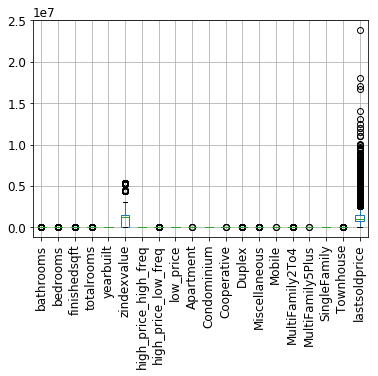

In [34]:
data_df.boxplot(rot = 90)
plt.show()

In [ ]:
From the above list, we do not find any value above 3. So there is no outlier. 
### No outlier assumption is satisfied.  

### 2) Normality of the residuals

#### We use Jarque-Bera test  from scipy library to check the normality of residuals.

#### Null Hypothesis: The residuals are normally distributed.

####  Alternative Hypothesis: The residuals are not normally distributed.


In [37]:
jb_stat, jb_pval = stats.jarque_bera(resid)
print('Jarque-Bera test P value is %1.4f' % jb_pval)

Jarque-Bera test P value is 0.0000


Since p value is 0, we reject the null hypothesis and conclude that residuals are not normally distributed.

### 3) Constant variance

Checking heteroscedasticity Using Goldfeld Quandt we test for heteroscedasticity.

* Null Hypothesis: Error terms are homoscedastic
* Alternative Hypothesis: Error terms are heteroscedastic.

In [35]:
resid           =  y_pred - y

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(resid, X)
lzip(name, test)

[('F statistic', 0.28922327658587094), ('p-value', 0.9999999999999999)]

The p-value is 0.99 hence we can say that the residuals have constant variance. 

### 4) No autocorrelation

#### Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

####  Null Hypothesis: Autocorrelation is absent.
#### Alternative Hypothesis: Autocorrelation is present.

In [36]:
diag.acorr_ljungbox(resid, lags = 1) 

(array([58.8322275]), array([1.71705725e-14]))

Since p-value is 1.72 e-14 thus we reject the null hypothesis and can say that autocorrelation is present.

### 5) Linearity

The residual vs fitted values plot is used to check for constant variance and linearity, and to identify potential outliers in the data.

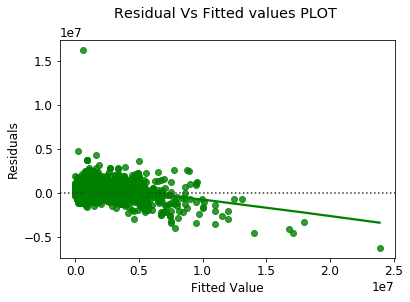

In [39]:
residuals  =  resid
# Plot the residuals after fitting a linear model
ax         = sns.residplot(y, residuals, lowess = True, color = "g")

ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

The residual plot indicates that the model’s residuals are not restricting to mean of zero to a great extent exhibiting non-linearity.

### Detect multi-collinearity

In [41]:
vif = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
print(vif)

D:\Python\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[2.866620053475559, 2.951161081621924, 3.335337278309442, 1.0306283171301571, 1.5090631712353801, 1.6513451919925337, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 2.2379227319429664]


In [ ]:
seed                  =   12345

lm                    =   LinearRegression()
lm_ridge              =   Ridge()
lm_lasso              =   Lasso()
lm_elastic            =   ElasticNet()
lm_elastic            =   ElasticNet()

### Non linear models

kfold                 =   model_selection.KFold(n_splits = 10, random_state = seed)
lm_CART               =   DecisionTreeRegressor()
lm_RF                 =   RandomForestRegressor(random_state = seed)
lm_ANN                =   MLPRegressor(alpha=0.0000001, activation = 'relu', random_state = seed, tol=0.0001)
lm_GB                 =   ensemble.GradientBoostingRegressor()
lm_SVR                =   SVR(kernel='linear', C=1.0, epsilon=0.2, )
lm_KNN                =   KNeighborsRegressor()

lm.fit(X, y)
lm_ridge.fit(X, y)
lm_lasso.fit(X, y)
lm_elastic.fit(X, y) 
lm_CART.fit(X, y) 
lm_RF.fit(X, y)
lm_GB.fit(X, y)
lm_SVR.fit(X, y)  
lm_KNN.fit(X, y)  
lm_ANN.fit(X, y)

In [ ]:
print('\nLinear Models\n')
print("R Square value for Simple Regression complete data %4.2f" % np.round(lm.score(X, y) * 100, 2))
print("R Square value for Ridge Regression complete data %4.2f" % np.round(lm_ridge.score(X, y) * 100, 2))
print("R Square value for Lasso Regression complete data %4.2f"  %np.round(lm_lasso.score(X, y) * 100, 2))
print("R Square value for Elastic Net Regression complete data %4.2f" % np.round(lm_elastic.score(X,y) * 100, 2))

print('\nNon linear Models\n')
print("R Square value for CART Regression complete data %4.2f" % np.round(lm_CART.score(X,y) * 100, 2))
print("R Square value for Random Forest Regression complete data %4.2f" % np.round(lm_RF.score(X,y) * 100, 2))
print("R Square value for Artificial Neural Network Regression complete data %4.2f" % np.round(lm_ANN.score(X,y) * 100, 2))

print("R Square value for Gradient Boosting Regression complete data %4.2f" % np.round(lm_GB.score(X,y) * 100, 2))
print("R Square value for SVR Regression complete data %4.2f" % np.round(lm_SVR.score(X,y) * 100, 2))
print("R Square value for KNN Regression complete data %4.2f" % np.round(lm_KNN.score(X,y) * 100, 2))

http://www.briandolhansky.com/blog/artificial-neural-networks-linear-regression-part-1